In [2]:
import numpy as np
import matplotlib.pyplot as plt

# NN Dev

In [1148]:
class NeuralNetwork:
    def __init__(self, input_size, l1_size, l2_size, output_size, init=(-1., 1.), learning_rate=0.01, dtype = np.float64):
        self.input_size = input_size
        self.l1_size = l1_size
        self.l2_size = l2_size
        self.output_size = output_size
        
        self.W1 = np.random.uniform(low=init[0], high=init[1], size=(self.input_size, self.l1_size)).astype(dtype)
        # self.W1 = np.ones(shape=(self.input_size, self.l1_size), dtype=dtype)
        self.W2 = np.random.uniform(low=init[0], high=init[1], size=(self.l1_size, self.l2_size)).astype(dtype)
        # self.W2 = np.ones(shape=(self.l1_size, self.l2_size), dtype=dtype) 
        self.W3 = np.random.uniform(low=init[0], high=init[1], size=(self.l2_size, self.output_size)).astype(dtype) 
        # self.W3 np.ones(shape=(self.l2_size, self.output_size), dtype=dtype)

        self.alpha = learning_rate
        
    
    def forward(self, x_):
        # Layer 1
        self.x_ = x_
        self.l1_ = self.x_ @ self.W1
        self.a1_ = sigmoid(self.l1_)
        #self.g1 = d_sigmoid(self.l1_)
        # Layer 2
        self.l2_ = self.a1_ @ self.W2
        self.a2_ = sigmoid(self.l2_)
        #self.g2 = d_sigmoid(self.l2_)
        # Layer 3
        self.o_ = self.a2_ @ self.W3
        self.s_ = softmax(self.o_)
        #self.g3 = d_softmax(self.o_)

        return self.s_
    
    def backward(self, y_, output_):
        tmp = d_mse(output_, y_) @ d_softmax(self.o_)
        self.dW3 = self.a2_.reshape(self.l2_size, 1) @ tmp
        tmp2 = d_sigmoid(self.l2_).reshape(self.l2_size, 1) @ (tmp @ self.W3.transpose())
        self.dW2 = tmp2 * self.a1_.reshape(self.l1_size, 1)
        self.dW1 = (self.x_.reshape(self.input_size, 1) @ d_sigmoid(self.l1_).reshape(self.l1_size, 1).transpose()) @ (tmp2 @ self.W2.transpose())

        self.W3 = self.W3 - self.alpha * self.dW3
        self.W2 = self.W2 - self.alpha * self.dW2 
        self.W1 = self.W1 - self.alpha * self.dW1
    
    def train(self, X, Y):
        self.outputs = []
        self.losses = []
        for i in range(X.shape[0]):
            output = self.forward(X[i]).reshape((1, self.output_size))
            if len(self.outputs) == 0:
                self.outputs = output
            else:
                np.append(self.outputs, output, axis=0)
            actual = Y[i].reshape((1, self.output_size))
            self.losses.append(mse(output, actual))
            self.backward(actual, output)
        return self.losses

def el_sig(x):
    return 1 / (1 + np.exp(-x))

def sigmoid(x_):
    l = [el_sig(xi) if xi > -200 else 0.0 for xi in x_]
    return np.array(l)

def d_sigmoid(x_):
    return sigmoid(x_)*(1 - sigmoid(x_))

def softmax(x_):
    return np.exp(x_) / np.sum(np.exp(x_))

def d_softmax(x_):
    Ds = np.zeros(shape=(len(x_), len(x_)))
    for i in range(len(x_)):
        for j in range(len(x_)):
            if i == j:
                Ds[i][j] = softmax(x_)[i] * (1 - softmax(x_)[j])
            else:
                Ds[i][j] = -softmax(x_)[i] * softmax(x_)[j]
    return Ds

def mse(O, Y):
    N = O.shape[0]
    mse_ = np.zeros(shape=(1, O.shape[1]), dtype=np.float64)
    for i in range(N):
        mse_ += (O[i] - Y[i])**2
    mse_ = (1 / N) * mse_
    return mse_

def d_mse(O, Y):
    N = O.shape[0]
    d_mse_ = np.zeros(shape=(1, O.shape[1]), dtype=np.float64)
    for i in range(N):
        d_mse_ += (O[i] - Y[i])
    d_mse_ = (2 / N) * d_mse_
    return d_mse_


## NN Testing

### NN init test

In [526]:
nn = NeuralNetwork(3, 4, 4, 2, (0, 1))
print(nn.W1.shape)
print(nn.W2.shape)
print(nn.W3.shape)

(3, 4)
(4, 4)
(4, 2)


### Sigmoid overflow & derivative

In [1003]:
sig_test = np.array([0, 1, -1, 1000, -1000])
sigmoid(sig_test)

array([0.5       , 0.73105858, 0.26894142, 1.        , 0.        ])

In [1004]:
print(sigmoid([-200.0]))
print(sigmoid([-199.0]))

[0.]
[3.76182078e-87]


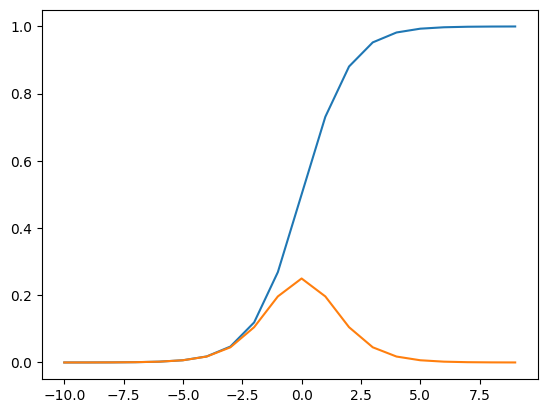

In [1011]:
plt.plot([i for i in range(-10,10)], [sigmoid([i]) for i in range(-10,10)])
plt.plot([i for i in range(-10,10)], [d_sigmoid([i]) for i in range(-10,10)])
plt.show()

In [1005]:
d_sigmoid(sig_test)

array([0.25      , 0.19661193, 0.19661193, 0.        , 0.        ])

### Forward pass

In [529]:
a = np.array([1, 2, 3]).reshape(1, 3)
print(a.shape)
print(a)
nn.forward(a[0])

(1, 3)
[[1 2 3]]


array([0.43237752, 0.56762248])

### Softmax derivative

In [530]:
t = np.array([1, 2, 3])
print(t)
print(softmax(t))
print(d_softmax(t))

[1 2 3]
[0.09003057 0.24472847 0.66524096]
[[ 0.08192507 -0.02203304 -0.05989202]
 [-0.02203304  0.18483645 -0.1628034 ]
 [-0.05989202 -0.1628034   0.22269543]]


### MSE derivative

In [573]:
T = np.array([[0, 1, 0], [0, 0, 1]])
print(T)
print(T.shape)
A = np.array([softmax([0, 1, 2]), softmax([1, 2, 0])])
print(A)
print(A.shape)
print(mse(T, A))
print(d_mse(T, A))

[[0 1 0]
 [0 0 1]]
(2, 3)
[[0.09003057 0.24472847 0.66524096]
 [0.24472847 0.66524096 0.09003057]]
(2, 3)
(2, 3)
(2, 3)
[[0.03399876 0.50649031 0.63529494]]
[[-0.33475904  0.09003057  0.24472847]]


### Backward pass, loss, weight update

In [1147]:
hidden_dim = 5
X = np.array([[0, 0, 0, 1]])
Y= np.array([[0, 1, 0]])
nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)

output_ = nn.forward(X[0]).reshape((1, nn.output_size))
y_ = Y[0].reshape((1, nn.output_size))
print(f"Output :{output_.shape}")
print(f"d MSE :{d_mse(output_, y_).shape}")
print(f"d Softmax :{d_softmax(nn.o_).shape}")
print(f"Activation2 :{nn.a2_.reshape(nn.l2_size, 1).shape}")
print(f"W3 :{nn.W3.shape}")
tmp = d_mse(output_, y_) @ d_softmax(nn.o_)
nn.dW3 = nn.a2_.reshape(nn.l2_size, 1) @ tmp
print(f"W3 update :{nn.dW3.shape}")
print("--------------------------------------------------------------------------------------------------")
print(f"d Sigmoid2 :{d_sigmoid(nn.l2_).reshape(nn.l1_size, 1).shape}")
print(f"Activation1 :{nn.a1_.reshape(nn.l1_size, 1).shape}")
print(f"W2 :{nn.W2.shape}")
# TODO fix this update
tmp2 = d_sigmoid(nn.l2_).reshape(nn.l2_size, 1) @ (tmp @ nn.W3.transpose())
nn.dW2 = tmp2 * nn.a1_.reshape(nn.l2_size, 1)
print(f"W2 update:{nn.dW2.shape}")
print("--------------------------------------------------------------------------------------------------")
print(f"d Sigmoid1 :{d_sigmoid(nn.l1_).reshape(nn.l1_size, 1).shape}")
print(f"X :{X[0].reshape(nn.input_size, 1).shape}")
print(f"W1 :{nn.W1.shape}")
# TODO fix this update
nn.dW1 = (nn.x_.reshape(nn.input_size, 1) @ d_sigmoid(nn.l1_).reshape(nn.l1_size, 1).transpose()) @ (tmp2 @ nn.W2.transpose())
print(f"W1 update:{nn.dW1.shape}")

Output :(1, 3)
d MSE :(1, 3)
d Softmax :(3, 3)
Activation2 :(5, 1)
W3 :(5, 3)
W3 update :(5, 3)
--------------------------------------------------------------------------------------------------
d Sigmoid2 :(5, 1)
Activation1 :(5, 1)
W2 :(5, 5)
W2 update:(5, 5)
--------------------------------------------------------------------------------------------------
d Sigmoid1 :(5, 1)
X :(4, 1)
W1 :(4, 5)
W1 update:(4, 5)


In [1186]:
hidden_dim = 5
X = np.array([[0, 0, 0, 1]])
Y= np.array([[0, 1, 0]])
nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)

from IPython.display import clear_output

def do_iteration(i):
    clear_output()
    print(f"Iteration: {i}")
    out = nn.forward(X[0]).reshape((1, nn.output_size))
    print("Prediction")
    print(f"Net output: {out}  --> {np.argmax(out)}")
    act =  Y[0].reshape(1,3)
    print("Expected value")
    print(f"One Hot: {act}  --> {np.argmax(act)}")
    loss = np.sum(mse(out,act))
    print(f"Loss: {loss}")
    nn.backward(act, out)
    return loss

#### Manually Click an watch loss go down

In [1191]:
i = 0
do_iteration(i)
i += 1

Iteration: 0
Prediction
Net output: [[0.38571699 0.33032616 0.28395685]]  --> 0
Expected value
One Hot: [[0 1 0]]  --> 1
Loss: 0.6778721401321324


#### Plot loss over many iterations

Iteration: 999
Prediction
Net output: [[0.03179583 0.93828462 0.02991955]]  --> 1
Expected value
One Hot: [[0 1 0]]  --> 1
Loss: 0.005714941681956217


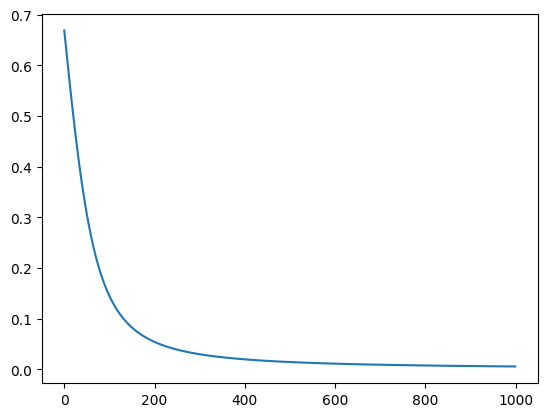

In [1192]:
iterations = []
losses = []
for i in range(1000):
    iterations.append(i)
    losses.append(do_iteration(i))

plt.plot(iterations, losses)
plt.show()

### Training

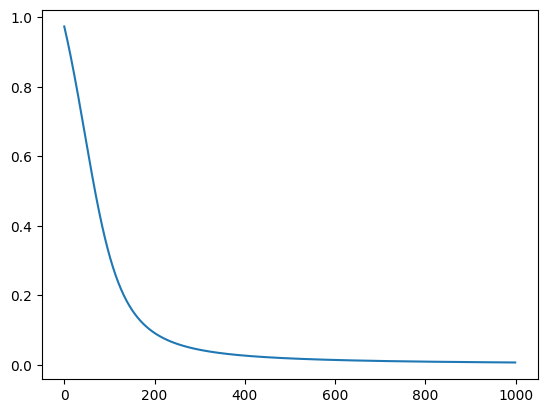

In [1193]:
hidden_dim = 5
X = np.array([[0, 0, 0, 1] for _ in range(1000)])
Y= np.array([[0, 1, 0] for _ in range(1000)])
nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)
losses = nn.train(X, Y)
plt.plot([i for i in range(1000)], [np.sum(l) for l in losses])
plt.show()

# MNIST

### Data Prep

In [1194]:
with open("./train.csv") as f:
    data = f.readlines()
data = data[1:]
data = np.array([[int(x) for x in line.split(",")] for line in data])
data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [1195]:
def plot_image(image):
    c = 0
    for pixel in image:
        if pixel > 0:
            print("@", end="")
        else:
            print(".", end="")
        print("   ", end="")
        c += 1
        if c == 28:
            print("\n")
            c = 0

In [1196]:
X = data[:, 1:]
plot_image(X[0])
X.shape

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   .   

(42000, 784)

In [1197]:
X.dtype

dtype('int32')

In [1198]:
Y = data[:, [0]]
Y.shape

(42000, 1)

In [1199]:
def one_hot(value, N=10):
    vec = np.zeros(N)
    vec[value] = 1
    return vec

In [1200]:
Y = np.array([one_hot(c) for c in Y])
Y.shape

(42000, 10)

### Mnist NN

In [1201]:
hidden_dim = 256
mnist_nn = NeuralNetwork(X.shape[1], hidden_dim, hidden_dim, Y.shape[1], (-0.3,0.3), 0.02, np.float64)

In [1202]:
losses = mnist_nn.train(X, Y)

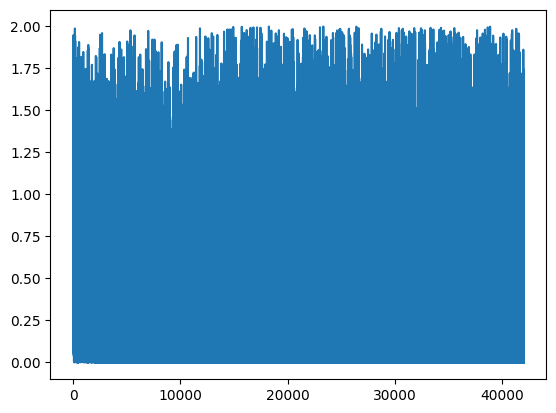

In [1206]:
summed_losses = [np.sum(l) for l in losses]
plt.plot([i for i in range(len(summed_losses))], summed_losses)
plt.show()

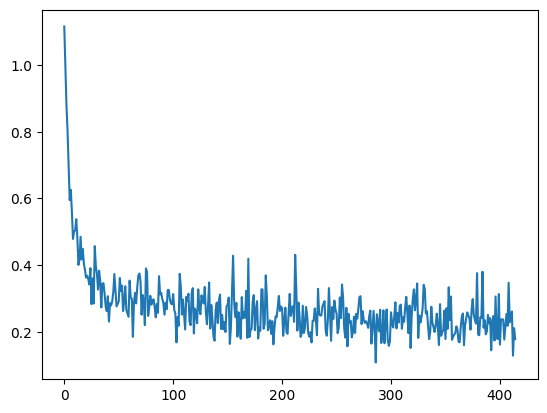

In [1207]:
def rolling_mean(series, window):
    rolled = []
    c = 0
    mean = 0
    for i in series:
        if c < window:
            mean += i / window
            c += 1
        else:
            c = 0
            rolled.append(mean)
            mean = 0
    return rolled

rolled = rolling_mean(summed_losses, 100)
plt.plot([i for i in range(len(rolled))], rolled)
plt.show()

In [1217]:
accuracy = 0
for i in range(len(X)):
    prediction = np.argmax(mnist_nn.forward(X[i]))
    actual = np.where(Y[i] == 1)[0][0]
    accuracy += int(actual == prediction)
accuracy / len(X)

0.8373333333333334

In [1216]:
i = 6070
prediction = np.argmax(mnist_nn.forward(X[i]))
actual = np.where(Y[i] == 1)[0][0]
print(f"Actual: {actual}, Prediction: {prediction}")
plot_image(X[i])

Actual: 5, Prediction: 5
0
.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @   @   @   @   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   @   @   .   @   @   @   @   @   @   @   @   @   .   .   .   

.   .   .   .   .   .   .   .   .   .   .   .   .   @   @   @